In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!pip3 install scikit-digital-health

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 37.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4


In [3]:
import os
from os import listdir
import random
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import skdh
from skdh import Pipeline
from skdh.gait import GaitLumbar, PredictGaitLumbarLgbm
from skdh.gait.gait_metrics import GaitEventEndpoint
from numpy import ones, zeros, nonzero, array, int_
from skdh.base import BaseProcess, handle_process_returns



In [4]:
# start from the sampled dataframe
all_samples = pd.read_csv('/content/gdrive/MyDrive/Next_Step/All_samples.csv')


In [5]:
# remove all the unneccesary columns
# all_samples = all_samples.drop(columns=['Unnamed: 0',' Latitude', ' SampleTimeFine' , ' Longitude',' Altitude', ' Vel_X', ' Vel_Y', ' Vel_Z'])

In [6]:
# interpolate
all_samples = all_samples.interpolate(method='linear', limit_direction='forward', axis=0)
# remove the calibration data points and the banked R/L to evaluate model performance
# without these variables because in our data collection they wont be included
all_samples = all_samples.drop(all_samples[all_samples["trial_label"] == 'calibration'].index)
# all_samples = all_samples.sort_values(by=['participant_num', 'trial_num', 'og_df_order'])

In [7]:
# seperating inputs by the sensor placement
all_samples_CC = all_samples.loc[all_samples['sensor_place'] == "CC"] # trunk
all_samples_95 = all_samples.loc[all_samples['sensor_place'] == "95"] # wrist
all_samples_93 = all_samples.loc[all_samples['sensor_place'] == "93"] # right thigh
all_samples_8B = all_samples.loc[all_samples['sensor_place'] == "8B"] # left thigh
all_samples_9B = all_samples.loc[all_samples['sensor_place'] == "9B"] # right shank
all_samples_B6 = all_samples.loc[all_samples['sensor_place'] == "B6"] # left shank

In [12]:
all_samples_CC_trial_4 = all_samples_CC.loc[all_samples_CC['trial_num'] == 4]

In [13]:
all_samples_CC_trial_4_ppant_7 = all_samples_CC_trial_4.loc[all_samples_CC_trial_4['participant_num'] == 7]

In [14]:
all_samples_CC_trial_4_ppant_7 = all_samples_CC_trial_4_ppant_7[['time_ms', ' Acc_X', ' Acc_Y', ' Acc_Z']]

In [15]:
all_samples_CC_trial_4_ppant_7

,time_ms,Acc_X,Acc_Y,Acc_Z
3606299,336530000000,9.621894,-0.299405,-1.563404
3606300,336540000000,9.582972,-0.237633,-1.467380
3606301,336550000000,9.564490,-0.219907,-1.404141
3606302,336560000000,9.570898,-0.231322,-1.321166
3606303,336570000000,9.600996,-0.186650,-1.276947
...,...,...,...,...
3607618,349720000000,10.521784,0.468691,-2.212522
3607619,349730000000,11.699749,0.834998,-1.812828
3607620,349740000000,12.855038,1.793443,-1.168001
3607621,349750000000,13.897147,2.369155,-0.788182


In [16]:
all_samples_CC_trial_4_ppant_7 = all_samples_CC_trial_4_ppant_7.set_axis(['time_ms','accel_X', 'accel_Y', 'accel_Z'], axis=1)

In [17]:
all_samples_CC_trial_4_ppant_7.to_csv('All_samples_4_7.csv', index=False)

In [18]:
class CreateStridesAndQc(BaseProcess):
    '''
    Top docstring
    '''

    def __init__(
        self,
        max_stride_time=lambda x: 2.0 * x + 1.0,
        loading_factor=lambda x: 0.17 * x + 0.05,
    ):
        super().__init__(
            max_stride_time=max_stride_time,
            loading_factor=loading_factor,
        )

        # ... init code

    @handle_process_returns(results_to_kwargs=True)
    def predict(
        self,
        time=None,
        initial_contacts=None,
        final_contacts=None,
        mean_step_freq=None,
        **kwargs,  # catches inputs required for future/previous processing steps
    ):
        '''
        predict docstring
        '''

        # Placeholder processing, replace this with your actual processing logic
        qc_ic = len(initial_contacts)  # Example: Number of initial contacts detected
        qc_fc = len(final_contacts)     # Example: Number of final contacts detected
        qc_fc_of = qc_fc                # Example: Number of final contacts detected on opposite foot
        forward_cycles = min(qc_ic, qc_fc)

        # setup results from this function
        res = {
            "qc_initial_contacts": qc_ic,
            "qc_final_contacts": qc_fc,
            "qc_final_contacts_oppfoot": qc_fc_of,
            "forward_cycles": forward_cycles,
        }

        return res


In [19]:
# Read CSV file and preprocess the data
data = skdh.io.ReadCSV(
    time_col_name="time_ms",
    column_names={'default': ['accel_X', 'accel_Y', 'accel_Z']},
    fill_gaps=True
).predict(file="/content/All_samples_4_7.csv")

# Preprocess gait bout
data_gait_bout = skdh.gait.substeps.PreprocessGaitBout(
    correct_orientation=True,
    filter_cutoff=20.0,
    filter_order=4,
    ap_axis_filter_kw=None
).predict(
    time=data['time'],
    accel=data['default'],  # Use 'default' stream for accelerometer data
    fs=data['fs'],          # Assuming 'fs' is the sampling frequency
    v_axis=None,
    ap_axis=None
)

# Detect gait events using Continuous Wavelet Transform (CWT)
gait_events = skdh.gait.substeps.VerticalCwtGaitEvents(
    use_cwt_scale_relation=True,
    wavelet_scale='default',
    round_scale=False
).predict(
    time=data['time'],
    accel_filt=data_gait_bout['accel_filt'],  # Use filtered acceleration data
    v_axis=data_gait_bout['v_axis'],     # Use vertical axis index
    v_axis_sign=data_gait_bout['v_axis_sign'],  # Use vertical axis sign
    fs=data['fs'],          # Assuming 'fs' is the sampling frequency
    mean_step_freq=data_gait_bout['mean_step_freq']  # Use mean step frequency
)

# Now, `gait_events` contains detected gait events such as initial contacts and final contacts
# You can use these results for downstream processing steps.


# Creating an instance of CreateStridesAndQc
process_instance = CreateStridesAndQc().predict(
    time=data['time'],
    initial_contacts=gait_events['initial_contacts'],
    final_contacts=gait_events['final_contacts'],
    mean_step_freq=data_gait_bout['mean_step_freq']
)

process_instance

{'qc_initial_contacts': 22,
 'qc_final_contacts': 21,
 'qc_final_contacts_oppfoot': 21,
 'forward_cycles': 21}

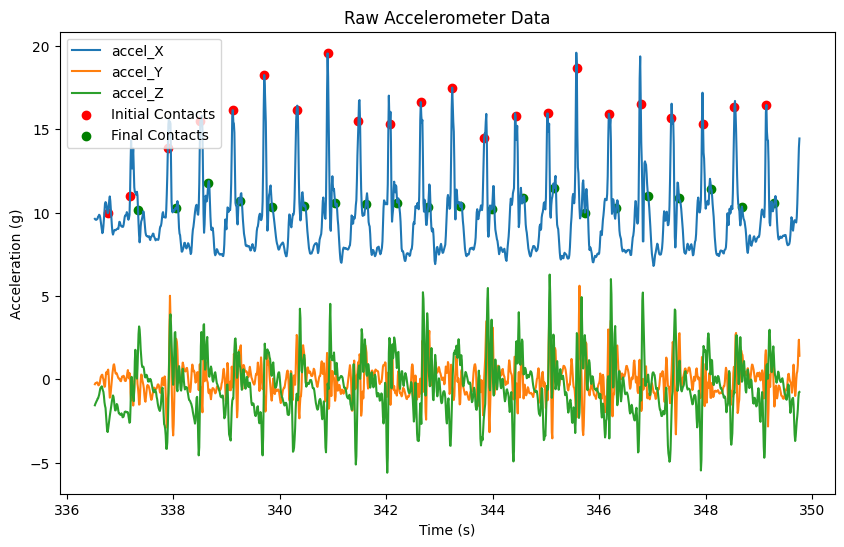

In [20]:
import matplotlib.pyplot as plt

# Plot raw accelerometer data
plt.figure(figsize=(10, 6))
plt.plot(data['time'], data['default'][:, 0], label='accel_X')
plt.plot(data['time'], data['default'][:, 1], label='accel_Y')
plt.plot(data['time'], data['default'][:, 2], label='accel_Z')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Raw Accelerometer Data')
plt.legend()

# Overlay detected steps
initial_contacts = gait_events['initial_contacts']
final_contacts = gait_events['final_contacts']
plt.scatter(data['time'][initial_contacts], data['default'][initial_contacts, 0], color='red', label='Initial Contacts')
plt.scatter(data['time'][final_contacts], data['default'][final_contacts, 0], color='green', label='Final Contacts')
plt.legend()

plt.show()